# 3.1 Build models

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np
# import seaborn as sns
import math
from sklearn.preprocessing import Imputer
from sklearn.base import TransformerMixin
from sklearn import cross_validation
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.cross_validation import cross_val_score
from sklearn.externals import joblib
import os

def sound():
    os.system('afplay /System/Library/Sounds/Sosumi.aiff')

%matplotlib inline
# sns.set_context('notebook')

path = '/'.join(os.getcwd().split('/')[:-2])
print(path)

/Volumes/Dropbox/largetransfer/luc/carter


In [2]:
df = pd.read_csv(path+'/data/model_data/tci_final_model.csv',index_col=0)

//anaconda/envs/data_sci/lib/python3.4/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
features = list(df.columns)
features.remove('vacant')
features.remove('Date')
features.remove('Survey Category')
features.remove('Survey Grade')
features.remove('SPA_NAME')
features.remove('style_filtered')
features.remove('LENDER_PROCESS_TYPE')

from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df[features], df['vacant'], test_size=0.2, random_state=42)

## Build the classifiers

### Random Forest Classifier

In [4]:
rfc = RandomForestClassifier(n_estimators=50, min_samples_leaf=8, min_samples_split=3, \
                                 class_weight={0:1, 1:8}, \
                                 max_features=20, random_state=0, max_depth=40)
rfc = rfc.fit(X_train, y_train)
sound()

In [5]:
# pd.crosstab(y_test, rfc.predict(X_test),rownames=['From survey'],colnames=['From model'],margins=True)
pd.crosstab(y_test,rfc.predict(X_test),colnames=['predicted by RF'])

predicted by RF,0,1
vacant,,
0,19804,790
1,733,1300


In [39]:
# pd.crosstab(y_test, rfc.predict(X_test),rownames=['From survey'],colnames=['From model'],margins=True)
pd.crosstab(y_test,rfc.predict(X_test),colnames=['predicted by RF'])

predicted by RF,0,1
vacant,,
0,19802,792
1,733,1300


In [6]:
pd.crosstab( y_test.values,pd.Series(rfc.predict_proba(X_test)[:,1]-.05).apply(lambda x: int(round(x))))

col_0,0,1
row_0,,
0,19949,645
1,792,1241


In [7]:
joblib.dump(rfc, path+'/data/models/rfc2.pkl') 

['/Volumes/Dropbox/largetransfer/luc/carter/data/models/rfc2.pkl',
 '/Volumes/Dropbox/largetransfer/luc/carter/data/models/rfc2.pkl_01.npy',
 '/Volumes/Dropbox/largetransfer/luc/carter/data/models/rfc2.pkl_02.npy',
 '/Volumes/Dropbox/largetransfer/luc/carter/data/models/rfc2.pkl_03.npy',
 '/Volumes/Dropbox/largetransfer/luc/carter/data/models/rfc2.pkl_04.npy',
 '/Volumes/Dropbox/largetransfer/luc/carter/data/models/rfc2.pkl_05.npy',
 '/Volumes/Dropbox/largetransfer/luc/carter/data/models/rfc2.pkl_06.npy',
 '/Volumes/Dropbox/largetransfer/luc/carter/data/models/rfc2.pkl_07.npy',
 '/Volumes/Dropbox/largetransfer/luc/carter/data/models/rfc2.pkl_08.npy',
 '/Volumes/Dropbox/largetransfer/luc/carter/data/models/rfc2.pkl_09.npy',
 '/Volumes/Dropbox/largetransfer/luc/carter/data/models/rfc2.pkl_10.npy',
 '/Volumes/Dropbox/largetransfer/luc/carter/data/models/rfc2.pkl_11.npy',
 '/Volumes/Dropbox/largetransfer/luc/carter/data/models/rfc2.pkl_12.npy',
 '/Volumes/Dropbox/largetransfer/luc/carter/d

In [8]:
dat = pd.DataFrame([rfc.predict_proba(X_test)[:,1], y_test, rfc.predict(X_test)]).T
dat = dat.rename(columns={0:'prob',1:'act',2:'pred'})

# sns.distplot(dat[(dat.act==1)&(dat.pred==1)].prob);
# sns.distplot(dat[(dat.act==0)&(dat.pred==1)].prob);
# sns.distplot(dat[(dat.act==1)&(dat.pred==0)].prob);
# sns.distplot(dat[(dat.act==0)&(dat.pred==0)].prob);
# plt.legend(['True vacant','False vacant','False Occupied','True Occupied'])

acc_neg = len(dat[(dat.act==0) & (dat.pred==0)])/len(dat[dat.act==0])
acc_pos = len(dat[(dat.act==1) & (dat.pred==1)])/len(dat[dat.act==1])
G = {}
F = {}
G['res'] = (acc_neg*acc_pos)**0.5
prec = len(dat[(dat.act==1) & (dat.pred==1)])/len(dat[dat.pred==1])
F['res'] = 2*prec*acc_pos/(prec+acc_pos)
print(G, F, prec, acc_pos)

{'res': 0.7841679560209562} {'res': 0.6306087800145526} 0.6220095693779905 0.6394490900147565


In [9]:
res = {}
for i in range(0,21):
    # copy = y_test.copy()
    p = i/20
    copy = pd.Series(rfc.predict_proba(X_test)[:,1],index=y_test.index)
    res[p] = {'correct': sum(y_test[copy.sort_values(ascending=False)[:int(len(X_test)*p)].index]), \
              'searched': len(y_test[copy.sort_values(ascending=False)[:int(len(X_test)*p)].index]), \
              'percent': sum(y_test[copy.sort_values(ascending=False)[:int(len(X_test)*p)].index])/sum(y_test) }
#     sum(y_test[copy.sort_values(ascending=False)[:int(len(X_test)*p)].index]), len(y_test[copy.sort_values(ascending=False)[:int(len(X_test)*p)].index]), sum(y_test)
res = pd.DataFrame(res).T

# plt.plot(res.index, res.percent)

## Importances

Feature ranking:
1. feature 26, days_since_ovv (0.192174)
2. feature 22, pv_count (0.094176)
3. feature 27, c_ovv_num (0.084636)
4. feature 25, boarded (0.080863)
5. feature 18, GRAND_TOTAL_PAID (0.064651)
6. feature 21, paid_percent (0.054621)
7. feature 31, fc_days (0.040226)
8. feature 32, sa_days (0.035636)
9. feature 37, al_days (0.030372)
10. feature 38, price_per_sqft (0.026358)


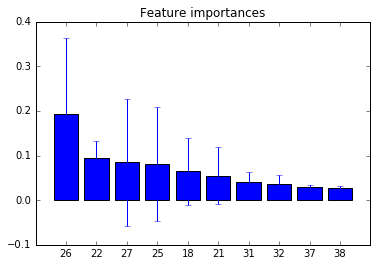

In [10]:
# plot the top ten features

importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. feature %d, %s (%f)" % (f + 1, indices[f], features[indices[f]], importances[indices[f]]))
    
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(10), importances[indices[0:10]], yerr=std[indices[0:10]], align="center")
plt.xticks(range(10), indices[0:10])
plt.xlim([-1, 10])
plt.show()

Feature ranking (least important):
1. feature 13, lb_tax_fc (0.000005)
2. feature 12, lb_acquired (0.000012)
3. feature 28, active_fc (0.000162)
4. feature 29, fc_1yr (0.000471)
5. feature 1, occup (0.002302)
6. feature 10, totbldgs (0.002492)
7. feature 30, fc_2yr (0.002961)
8. feature 2, rnumstor (0.003234)
9. feature 0, cqual_num (0.003465)
10. feature 23, v_total_1yr (0.003894)


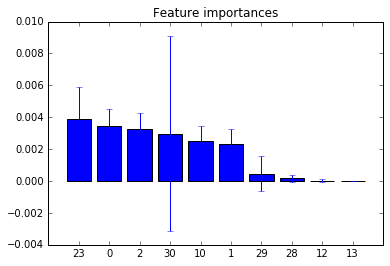

In [11]:
# Print the feature ranking
features2 = pd.DataFrame(features).iloc[indices[0:10]][0].values

print("Feature ranking (least important):")

for f in range(10):
    print("%d. feature %d, %s (%f)" % (f + 1, indices[-f-1], features[indices[-f-1]], importances[indices[-f-1]]))
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(10), importances[indices[-10:]], yerr=std[indices[-10:]], align="center")
plt.xticks(range(10), indices[-10:])
plt.xlim([-1, 10])
plt.show()

### Logistic Regressor

In [20]:
# features2 = ['c_O.V.V._2yr', 'pv_total','GRAND_TOTAL_BALANCE','condition_value','vacant',\
#              'totusabl', 'tmktval', 'fc_days', 'days_since_transfer', 'propsize', 'yrbuilt_filtered', 'al_days']

# # features2 = ['c_O.V.V._2yr', 'pv_total','GRAND_TOTAL_BALANCE','condition_value','vacant']

In [21]:
# train_lr = preprocessing.scale(X_train)
# test_lr = preprocessing.scale(X_test)

# lr = LogisticRegression(class_weight={0:1, 1:2}, random_state=1001)
# lr.fit(pd.DataFrame(train_lr, columns = features), y_train)
# pd.crosstab(y_test,lr.predict(test_lr))

In [12]:
lr = LogisticRegression(class_weight={0:1, 1:3}, random_state=1001)
lr.fit(pd.DataFrame(X_train, columns = features), y_train)
# pd.crosstab(y_test,lr.predict(X_test))

pd.crosstab(y_test,lr.predict(X_test),colnames=['predicted by LR'])

predicted by LR,0,1
vacant,,
0,19802,792
1,808,1225


In [14]:
pd.crosstab( y_test.values,pd.Series(lr.predict_proba(X_test)[:,1]-.1).apply(lambda x: int(round(x))))

col_0,0,1
row_0,,
0,20068,526
1,897,1136


In [15]:
dat = pd.DataFrame([lr.predict_proba(X_test)[:,1], y_test, lr.predict(X_test)]).T
dat = dat.rename(columns={0:'prob',1:'act',2:'pred'})

# sns.distplot(dat[(dat.act==1)&(dat.pred==1)].prob);
# sns.distplot(dat[(dat.act==0)&(dat.pred==1)].prob);
# sns.distplot(dat[(dat.act==1)&(dat.pred==0)].prob);
# sns.distplot(dat[(dat.act==0)&(dat.pred==0)].prob);
# plt.legend(['True vacant','False vacant','False Occupied','True Occupied'])

acc_neg = len(dat[(dat.act==0) & (dat.pred==0)])/len(dat[dat.act==0])
acc_pos = len(dat[(dat.act==1) & (dat.pred==1)])/len(dat[dat.act==1])
G['log_res'] = (acc_neg*acc_pos)**0.5
prec = len(dat[(dat.act==1) & (dat.pred==1)])/len(dat[dat.pred==1])
F['log_res'] = 2*prec*acc_pos/(prec+acc_pos)
print(G, F, prec, acc_pos)

{'log_res': 0.7611732701459691, 'res': 0.7841679560209562} {'log_res': 0.6049382716049383, 'res': 0.6306087800145526} 0.6073376301437778 0.602557796360059


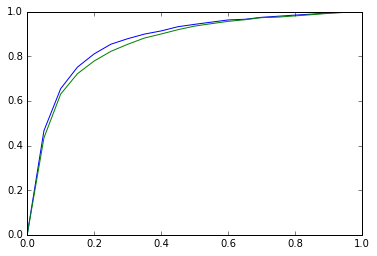

In [16]:
log_res = {}
for i in range(0,21):
    # copy = y_test.copy()
    p = i/20
    copy = pd.Series(lr.predict_proba(X_test)[:,1],index=y_test.index)
    log_res[p] = {'correct': sum(y_test[copy.sort_values(ascending=False)[:int(len(X_test)*p)].index]), \
              'searched': len(y_test[copy.sort_values(ascending=False)[:int(len(X_test)*p)].index]), \
              'percent': sum(y_test[copy.sort_values(ascending=False)[:int(len(X_test)*p)].index])/sum(y_test) }
#     sum(y_test[copy.sort_values(ascending=False)[:int(len(X_test)*p)].index]), len(y_test[copy.sort_values(ascending=False)[:int(len(X_test)*p)].index]), sum(y_test)
log_res = pd.DataFrame(log_res).T

plt.plot(res.index, res.percent)
plt.plot(log_res.index, log_res.percent)

In [17]:
importances = lr.coef_[0]
# std = np.std([tree.feature_importances_ for tree in lr.estimators_],
#              axis=0)
indices = np.argsort(abs(importances))[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(15):
    print("%d. feature %d, %s (%f)" % (f + 1, indices[f], features[indices[f]], importances[indices[f]]))
print("\nFeature ranking (least important):")
for f in range(10):
    print("%d. feature %d, %s (%f)" % (f + 1, indices[-f-1], features[indices[-f-1]], importances[indices[-f-1]]))

Feature ranking:
1. feature 22, pv_count (0.191113)
2. feature 8, cond_val (-0.144116)
3. feature 24, v_total_2yr (0.058445)
4. feature 23, v_total_1yr (0.044094)
5. feature 20, delq_total_ratio (0.028879)
6. feature 25, boarded (0.027112)
7. feature 21, paid_percent (-0.021705)
8. feature 1, occup (0.019688)
9. feature 9, ownerocc_value (-0.018903)
10. feature 30, fc_2yr (0.011447)
11. feature 10, totbldgs (-0.007405)
12. feature 35, t_num (-0.007263)
13. feature 0, cqual_num (-0.006964)
14. feature 38, price_per_sqft (-0.006346)
15. feature 15, TAX_ASSESSED_LAND (0.005144)

Feature ranking (least important):
1. feature 34, t_shf_deed (0.000001)
2. feature 5, tmktval (0.000005)
3. feature 3, propsize (-0.000022)
4. feature 6, mktbldg (-0.000023)
5. feature 37, al_days (0.000048)
6. feature 7, mktland (0.000051)
7. feature 19, GRAND_TOTAL_OWED (0.000071)
8. feature 32, sa_days (-0.000083)
9. feature 18, GRAND_TOTAL_PAID (-0.000096)
10. feature 33, t_days (-0.000097)


In [18]:
joblib.dump(lr, path+'/data/models/lr2.pkl') 

['/Volumes/Dropbox/largetransfer/luc/carter/data/models/lr2.pkl',
 '/Volumes/Dropbox/largetransfer/luc/carter/data/models/lr2.pkl_01.npy',
 '/Volumes/Dropbox/largetransfer/luc/carter/data/models/lr2.pkl_02.npy',
 '/Volumes/Dropbox/largetransfer/luc/carter/data/models/lr2.pkl_03.npy']

## xgboost

In [19]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {"objective": "binary:logistic"}
gbm = xgb.train(params, dtrain, 20)

In [20]:
# gbm.save_model(path+'/data/models/gbm2.pkl')
# bst = xgb.Booster() #init model
# bst.load_model(path+'/data/models/gbm2.pkl')

In [21]:
probs = gbm.predict(dtest)

In [22]:
y_test.shape

(22627,)

In [27]:
pd.crosstab( y_test.values,pd.Series(probs+.19).apply(lambda x: int(round(x))))

col_0,0,1
row_0,,
0,19980,614
1,789,1244


In [9]:
# t['preds'] = pd.Series(probs[:,1]+.23).apply(lambda x: int(round(x))).values

IndexError: too many indices for array

In [46]:
# t[['preds']].to_csv(path+'/data/predictions/xgb.csv')

In [47]:
# probs_train = gbm.predict_proba(xgtrain)
# pd.crosstab(y_train,pd.Series(probs_train[:,1]+.23).apply(lambda x: int(round(x))).values,rownames=['actual'],colnames=['predicted by GBM'])

In [48]:
# pd.crosstab(y_test,pd.Series(probs[:,1]+.23).apply(lambda x: int(round(x))).values,rownames=['actual'],colnames=['predicted by GBM'])

In [28]:
xgb_res = {}
for i in range(0,21):
    # copy = y_test.copy()
    p = i/20
    copy = pd.Series(probs+.22)
#     copy = pd.Series(probs[:,1],index=y_test.index)
    xgb_res[p] = {'correct': sum(y_test[copy.sort_values(ascending=False)[:int(len(X_test)*p)].index]), \
              'searched': len(y_test[copy.sort_values(ascending=False)[:int(len(X_test)*p)].index]), \
              'percent': sum(y_test[copy.sort_values(ascending=False)[:int(len(X_test)*p)].index])/sum(y_test) }
#     sum(y_test[copy.sort_values(ascending=False)[:int(len(X_test)*p)].index]), len(y_test[copy.sort_values(ascending=False)[:int(len(X_test)*p)].index]), sum(y_test)
xgb_res = pd.DataFrame(xgb_res).T

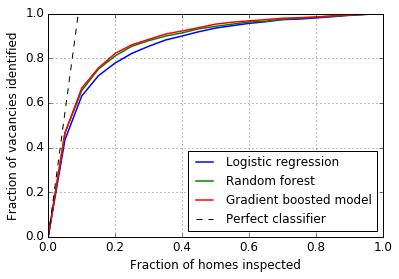

In [29]:
# sns.set_context('notebook')
# sns.set_style("whitegrid")
fig = plt.figure()
# fig, ax = plt.subplots()
# ax.plot(t, s)

plot = fig.add_subplot(111)
# ax.grid(True)
ax = fig.gca()
ax.grid(True)
plot.tick_params(axis='both', labelsize=12)
plt.plot(log_res.index, log_res.percent,linewidth=1.5)
plt.plot(res.index, res.percent,linewidth=1.5)
plt.plot(xgb_res.index, xgb_res.percent,linewidth=1.5)
plt.plot([0,sum(y_test)/len(y_test)],[0,1],'k--',linewidth=1)
plt.xlabel('Fraction of homes inspected',fontsize=12)
plt.ylabel('Fraction of vacancies identified',fontsize=12)
# plt.set_xticklabels(fontsize='small')
# plt.axis([-0.05,1.05,-0.05,1.05])
plt.legend(['Logistic regression','Random forest','Gradient boosted model','Perfect classifier'],loc='lower right',fontsize=12);
# plt.savefig(path+'/outputs/model_inspection_comparison.pdf')

In [30]:
tem = pd.concat([res[['correct']].iloc[range(0,22,2)], \
           log_res[['correct']].iloc[range(0,22,2)],\
           xgb_res[['correct']].iloc[range(0,22,2)] ], axis=1)

tem.columns = ['Random forest','Logistic regression','Gradient boosted']

tem

,Random forest,Logistic regression,Gradient boosted
0.0,0,0,0
0.1,1331,1282,1354
0.2,1648,1583,1671
0.3,1786,1735,1798
0.4,1857,1829,1875
0.5,1917,1901,1937
0.6,1957,1944,1967
0.7,1981,1978,1991
0.8,2001,1994,2002
0.9,2021,2017,2020


In [31]:
dat = pd.DataFrame([gbm.predict(dtest)+0.22, y_test, pd.Series(probs+.23).apply(lambda x: int(round(x))).values]).T
dat = dat.rename(columns={0:'prob',1:'act',2:'pred'})


# sns.distplot(dat[(dat.act==1)&(dat.pred==1)].prob);
# sns.distplot(dat[(dat.act==0)&(dat.pred==1)].prob);
# sns.distplot(dat[(dat.act==1)&(dat.pred==0)].prob);
# sns.distplot(dat[(dat.act==0)&(dat.pred==0)].prob);
# plt.legend(['True vacant','False vacant','False Occupied','True Occupied'])

acc_neg = len(dat[(dat.act==0) & (dat.pred==0)])/len(dat[dat.act==0])
acc_pos = len(dat[(dat.act==1) & (dat.pred==1)])/len(dat[dat.act==1])
G['xgb_res'] = (acc_neg*acc_pos)**0.5
prec = len(dat[(dat.act==1) & (dat.pred==1)])/len(dat[dat.pred==1])
F['xgb_res'] = 2*prec*acc_pos/(prec+acc_pos)
print(G, F, prec, acc_pos)

{'xgb_res': 0.7824466674752601, 'log_res': 0.7611732701459691, 'res': 0.7841679560209562} {'xgb_res': 0.6375092661230541, 'log_res': 0.6049382716049383, 'res': 0.6306087800145526} 0.6405163853028798 0.6345302508607968


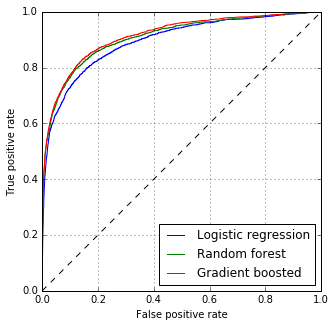

In [32]:
from sklearn.metrics import roc_curve

fig = plt.figure(figsize=[5,5])
plot = fig.add_subplot(111)

ax = fig.gca()
ax.grid(True)


# The logistic regression
y_pred_lr = lr.predict_proba(X_test)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_lr)

# The random forest model by itself
y_pred_rf = rfc.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)

# The random forest model by itself
y_pred_gb = gbm.predict(dtest)
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_pred_gb)

plt.plot(fpr_lr, tpr_lr, label='Logistic regression')
plt.plot(fpr_rf, tpr_rf, label='Random forest')
plt.plot(fpr_gb, tpr_gb, label='Gradient boosted')
plt.plot([0,1], [0,1],'k--')

plt.legend(loc='lower right');
plt.axis([0,1,0,1],'equal')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')

# plt.savefig(path+'/outputs/model_ROC.pdf').

In [68]:
r = pd.Series(gbm.predict(dtest)).apply(lambda x: 0 if x < 0.3 else 1)

In [74]:
r.values

array([0, 1, 0, ..., 0, 0, 0])

In [50]:
pred_r = rfc.predict_proba(X_test)
pred_g = gbm.predict(dtest)
pred_l = lr.predict_proba(X_test)
preds = pd.concat([pd.DataFrame(pred_r[:,1], index=y_test.index).rename(columns={0:'rf'}),\
       pd.DataFrame(pred_l[:,1], index=y_test.index).rename(columns={0:'lr'}),\
       pd.DataFrame(pred_g, index=y_test.index).rename(columns={0:'gbm'}),\
      y_test], axis=1).reset_index()

In [76]:
preds['avg'] = (preds['rf']+preds['lr']+preds['gbm'])/3.0

In [81]:
pd.crosstab(y_test.values,preds['gbm'].apply(lambda x: 1 if x>.3 else 0))

gbm,0,1
row_0,,
0,19980,614
1,788,1245


In [103]:
preds = pd.merge(preds, X_test[['pv_count']], how='left',left_on='parcel',right_index=True)
preds['pv_count'] = preds['pv_count'].apply(lambda x: 0 if x < 1 else 1)

In [104]:
pd.crosstab(y_test.values,preds.pv_count)

pv_count,0,1
row_0,,
0,19682,912
1,1131,902


In [93]:
sum(preds[(preds.gbm>0.3) & (preds.rf>0.4) & (preds.lr>0.5)].vacant),len(preds[(preds.gbm>0.3) & (preds.rf>0.4) & (preds.lr>0.5)].vacant)

(1141, 1558)

In [77]:
pd.crosstab(y_test.values,preds['avg'].apply(lambda x: 1 if x>.45 else 0))

avg,0,1
row_0,,
0,19978,616
1,779,1254
